# 종합 세금 전문 Agent

In [1]:
from textwrap import dedent     # tap(들여쓰기)에 상관없이 쓸 수 있게.
from pprint import pprint
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import TypedDict
from typing import Literal
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

In [3]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_engine="advanced",
    include_answers=True,
    include_raw_content=True,
    include_images=True,
)

### web 검색 전문

In [4]:
def web_search(state: AgentState) -> AgentState:
    """ 
    주어진 state를 기반으로 웹 검색을 수행합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.    
    """
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    
    return {'context': results}

In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model='gpt-4o')

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.
    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.      
    """
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    response = rag_chain.invoke({"context": context, "question": query})
    
    return {'answer': response}

c:\Users\scv31\Desktop\donghwan\workspace\aipython\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model='gpt-4o-mini')

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.      
    """
    query = state['query']
    
    llm_response = basic_llm.invoke(query)
    
    return {'answer': llm_response}

### Route 분기 전문 llm 추가

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class Route(BaseModel):
    # llm이 타겟중에서 호출 할 수 있도록 선언
    target: Literal['vector_store', 'llm', 'web_search', 'estate_collection'] = Field(
        description="The target for the query to answer"
    )  
    

In [8]:
router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', 'web_search', or 'estate_collection'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
if the question is related to real estate tax law, use 'estate_collection'
"""

In [9]:
router_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', router_system_prompt),
        ('human', "{query}")
    ]
)

# router 에게 llm 전달 [좋은 모델 x]
router_llm = ChatOpenAI(model='gpt-4o-mini')                    # 위에 선언된 3가지의 방법중 어떤걸 호출할지 판단하는 llm
structed_router_llm = router_llm.with_structured_output(Route)  # Route 객체와 맵핑된 객체 <현재 코드에선 선언된 Route.target 내부를 호출해야함.>

In [10]:
def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search', 'estate_collection']:
    """
    사용자의 질문을 기반으로 적절한 경로를 결정합니다.
    
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
        
    Returns:
        Literal['vector_store', 'llm', 'web_search', 'estate_collection']: 
        질문을 처리하기 위한 적절한 경로를 나타내는 문자열을 반환한다.      
    """
    query = state['query']
    
    router_chain = router_prompt | structed_router_llm
    
    route = router_chain.invoke({"query": query})
    print(f"route: {route.target}")
    return route.target

### 외부 세금 전문 Agent

In [11]:
from income_tax_agent import graph as income_tax_subgraph
from income_estate_tax import graph as income_estate_tax_subgraph

c:\Users\scv31\Desktop\donghwan\workspace\aipython\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
c:\Users\scv31\Desktop\donghwan\workspace\aipython\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
c:\Users\scv31\Desktop\donghwan\workspace\aipython\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


생성된 텍스트 청크 수: 17
각 청크의 길이: [1469, 1345, 295, 932, 1213, 1298, 1333, 1109, 1446, 1497, 1168, 1408, 1167, 1080, 1390, 1451, 1331]


c:\Users\scv31\Desktop\donghwan\workspace\aipython\uv_work\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 노드 추가

In [12]:
graph_builder = StateGraph(AgentState)
# 테스트용 노드 추가
graph_builder.add_node("income_tax_agent", income_tax_subgraph)
graph_builder.add_node("income_estate_tax", income_estate_tax_subgraph)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("basic_generate", basic_generate)

### 엣지 추가 및 분기

In [13]:
graph_builder.add_conditional_edges(
    START,
    router,
    {
        "vector_store":"income_tax_agent",
        "estate_collection":"income_estate_tax",
        "llm": "basic_generate",
        "web_search":"web_search"
    }
)
graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("basic_generate",END)
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("income_tax_agent", END)
graph_builder.add_edge("income_estate_tax", END)

### 그래프 시각화
그래프 작성 요청이 많으면 오류 발생 따라서, max_retries로 횟수 제한 하여 요청하도록 변경

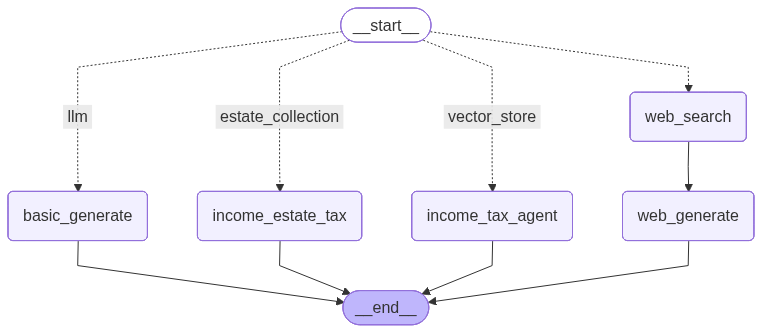

In [15]:
graph = graph_builder.compile()
# display(Image(graph.get_graph().draw_mermaid_png()))

png = graph.get_graph().draw_mermaid_png(
    max_retries=5,        # default ~3
    retry_delay=2.0       # seconds between tries
)
display(Image(png))

### Nomal 답변

In [16]:
inital_state = {'query': "대한민국 수도는 어디인가요?"}
graph.invoke(inital_state)

route: llm


{'query': '대한민국 수도는 어디인가요?',
 'answer': AIMessage(content='대한민국의 수도는 서울입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'finish_reason': 'stop', 'logprobs': None}, id='run--c959017d-05db-459a-b0b6-7433ecbda43c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

### Web 검색 답변

In [17]:
inital_state = {'query': "광주 문화전당역 맛집을 추천해주세요?"}
graph.invoke(inital_state)

route: web_search


{'query': '광주 문화전당역 맛집을 추천해주세요?',
 'context': "HTTPError('401 Client Error: Unauthorized for url: https://api.tavily.com/search')",
 'answer': '죄송합니다, 현재 광주 문화전당역 주변 맛집 정보를 제공할 수 없습니다.'}

### 소득세법 Agent

In [20]:
inital_state = {'query': "연봉 5천만원 직장인의 소득세는 얼마인가요?"}
graph.invoke(inital_state)

route: vector_store
응답: not hallucinated
유용성: helpful


{'query': '거주자의 연봉 5천만원에 대한 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='③ 제1항 및 제2항에 따른 이자등 상당액의 계산방법과 그 밖에 필요한 사항은 대통령령으로 정한다.\n\n[전문개정 2009. 12. 31.]\n\n\n\n제46조(채권 등에 대한 소득금액의 계산 특례) ① 거주자가 제16조제1항제1호ㆍ제2호ㆍ제2호의2ㆍ제5호 및 제6호에 해당하는 채권 또는 증권과 타인에게 양도가 가능한 증권으로서 대통령령으로 정하는 것(이하 이 조, 제133조의2 및 제156조의3에서 “채권등”이라 한다)의 발행법인으로부터 해당 채권등에서 발생하는 이자 또는 할인액(이하 이 조, 제133조의2 및 제156조의3에서 “이자등”이라 한다)을 지급[전환사채의 주식전환, 교환사채의 주식교환 및 신주인수권부사채의 신주인수권행사(신주 발행대금을 해당 신주인수권부사채로 납입하는 경우만 해당한다) 및 「자본시장과 금융투자업에 관한 법률」 제4조제7항제3호ㆍ제3호의2 및 제3호의3에 해당하는 채권등이 주식으로 전환ㆍ상환되는 경우를 포함한다. 이하 같다]받거나 해당 채권등을 매도(증여ㆍ변제 및 출자 등으로 채권등의 소유권 또는 이자소득의 수급권의 변동이 있는 경우와 매도를 위탁하거나 중개 또는 알선시키는 경우를 포함하되, 환매조건부채권매매거래 등 대통령령으로 정하는 경우는 제외한다. 이하 제133조의2에서 같다)하는 경우에는 거주자에게 그 보유기간별로 귀속되는 이자등 상당액을 해당 거주자의 제16조에 따른 이자소득으로 보아 소득금액을 계산한다. <개정 2010. 12. 27., 2012. 1. 1., 2020. 12. 29.>\n\n② 제1항을 적용할 때 해당 거주자가 해당 채권등을 보유한 기간을 대통령령으로 정하는 바에 따라 입증하지 못하는 경우에는 제133조의2제1항에 따른 원천징수기간의 이자등 상당액이 해당 거주자에게 귀속되는 것으로 보아 소득금액을 계산

### 부동산세법 Agent

In [19]:
inital_state = {'query': "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"}
graph.invoke(inital_state)


route: estate_collection


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '주어진 정보를 바탕으로 종합부동산세를 계산해보겠습니다. 사용자는 총 3채의 주택을 보유하고 있으며, 총 공시가격은 35억 원입니다. 공제금액은 9억 원으로, 과세 대상 금액은 26억 원입니다. 사용자는 3주택 이상을 소유하고 있으므로 이에 대한 세율을 적용해야 합니다.\n\n1. **과세표준 계산**:\n   - 3억 원 이하 부분: 3억 원 × 0.005 = 150만 원\n   - 3억 원 초과 6억 원 이하 부분: (6억 원 - 3억 원) × 0.007 = 210만 원\n   - 6억 원 초과 12억 원 이하 부분: (12억 원 - 6억 원) × 0.01 = 600만 원\n   - 12억 원 초과 25억 원 이하 부분: (25억 원 - 12억 원) × 0.02 = 2,600만 원\n   - 25억 원 초과 26억 원 이하 부분: (26억 원 - 25억 원) × 0.03 = 30만 원\n\n2. **총 세금 계산**:\n   - 총 세금 = 150만 원 + 210만 원 + 600만 원 + 2,600만 원 + 30만 원 = 3,590만 원\n\n따라서, 사용자는 종합부동산세로 총 3,590만 원을 납부해야 합니다.'}